In [1]:
# # !pip3 install "gymnasium[toy-text]"
# import gymnasium as gym

# env = gym.make('CliffWalking-v0', render_mode="human")
# state, info = env.reset()

# done = False
# steps=0
# # while not done:
# #     action = env.action_space.sample()
# #     next_state, reward, terminated, truncated, info = env.step(action)
# #     done = terminated or truncated
# #     state = next_state
# #     steps+=1
# #     # print(steps)

# env.close()

In [2]:
# # Action Space: Discrete(4)
# # Number of possible actions: 4

# # Possible actions:
# # 0: UP
# # 1: RIGHT
# # 2: DOWN
# # 3: LEFT

# def get_possible_actions(state):
#     return env.action_space.sample()

# def get_next_step(state, action):
#     current_state = env.unwrapped.s
#     env.unwrapped.s = state
#     next_state, reward, terminated, truncated, info = env.step(action)
#     env.unwrapped.s = next_state
#     return reward, next_state

# # Example usage:
# state = 36  # Some state in the grid (states are numbered 0-47)
# action = 1  # RIGHT


# print(get_possible_actions(state))
# print(get_next_step(state, action))

In [15]:
import numpy as np
import gymnasium as gym

class CliffWalking:
    def __init__(self):
        # Initialize gym environment
        self.env = gym.make('CliffWalking-v0')
        
        # Grid dimensions from gym
        self.states = self.env.observation_space.n
        self.actions = list(range(self.env.action_space.n))  # Convert to list to make iterable
        self.current_state = self.env.reset()[0]
        
        # Define states
        self.cliff = [(3,j) for j in range(1,11)]  # Cliff positions in bottom row
        self.goal = (3,11)  # Bottom right corner
        self.current_state = self.env.reset()[0]

    def get_next_state(self, state, action):
        # Save current state
        original_state = self.env.unwrapped.s
        
        # Convert state coordinates to single integer if needed
        if isinstance(state, tuple):
            state = state[0] * 12 + state[1]  # Convert (row, col) to single integer
        
        # Set environment to desired state and reset if needed
        self.env.unwrapped.s = state
        if not hasattr(self.env, '_has_reset') or not self.env._has_reset:
            self.env.reset()
            self.env.unwrapped.s = state
            
        # Get next state
        next_state = self.env.step(action)[0]
        
        # Restore original state
        self.env.unwrapped.s = original_state
        return next_state

    def step(self,action):
        return self.env.step(action)[0], self.env.step(action)[1], self.env.step(action)[2]


In [22]:
from Montecarlotree import MonteCarloSearchTree
from tqdm import tqdm
def plot_graph_for_test(env):
    mins = {}
    maxs = {}
    avgs = {}
    budget = {}
    iterations = [10,50,100,500,1000,10000]
    for i in iterations:
        mcts = MonteCarloSearchTree(env)
        # Convert initial state (0,0) to integer representation
        mcts.root.state = 0  # (0 * 12 + 0)
        values = []
        for _ in tqdm(range(5)):
            prob, value = mcts.get_best_action(i)
            values.append(value)
        mins[i] = min(values)
        maxs[i] = max(values)
        avgs[i] = sum(values)/len(values)
        budget[i] = i
    return mins, maxs, avgs, budget



env = CliffWalking()
mins, maxs, avgs, budget = plot_graph_for_test(env)
print(mins)
print(maxs)
print(avgs)
print(budget)



100%|██████████| 5/5 [28:06<00:00, 337.26s/it]

{10: -89.21174916269145, 50: -32.42811785034213, 100: -30.765441394890377, 500: -8.65186542643805, 1000: -4.716432384561084, 10000: -0.377471971444655}
{10: -60.584179329428245, 50: -32.42811785034213, 100: -7.554206155433661, 500: -1.719774850735023, 1000: -0.9406503677124083, 10000: -0.07547023414994826}
{10: -71.45357801649871, 50: -32.42811785034213, 100: -15.744126018351059, 500: -3.940274890482607, 1000: -2.150193025860492, 10000: -0.17235410982878202}
{10: 10, 50: 50, 100: 100, 500: 500, 1000: 1000, 10000: 10000}


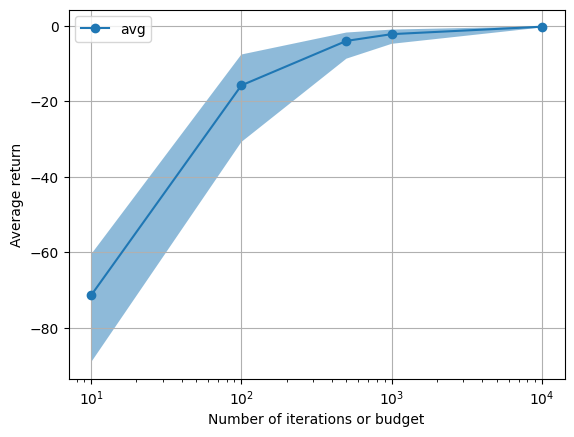

In [85]:
# print(avgs)
import matplotlib.pyplot as plt

y_values = [val for i, val in enumerate(avgs.values()) if i != 1]
x_values = [10,100,500,1000,10000]  # Removed 100
plt.plot(x_values, y_values, label='avg', marker='o')
plt.fill_between(x_values,
                [val for i, val in enumerate(mins.values()) if i != 1],
                [val for i, val in enumerate(maxs.values()) if i != 1],
                alpha=0.5)
plt.grid(True)
plt.legend()
plt.xlabel('Number of iterations or budget')
plt.ylabel('Average return')
plt.xscale('log')
plt.show()

In [83]:
# Move the function definition outside the multiprocessing code and wrap everything in a main function
def run_single_iteration(state, env, mcts):
    print(f'Processing state: {state}',end=':')
    action_count = [0,0,0,0]  # Up, Right, Down, Left
    if state != 47:  # If not goal state (3,11)
        env.current_state = state
        mcts.root = Node(state)
        probs_pi_state, optimal_value = mcts.get_best_action(1000, min_visits=2000)
        optimal_action = np.argmax(probs_pi_state)
        action_count[optimal_action] += 1
        print(f'op: {optimal_action}')
    return probs_pi_state, optimal_value, action_count

def main():
    env = CliffWalking()
    mcts = MonteCarloSearchTree(env)
    mcts.depth_limit = 50
    probs_pi = {}
    pi = {}
    with tqdm(total=4*12, desc='Processing states') as pbar:
        for i in range(4):
            for j in range(12):
                state = i * 12 + j
                # Replace multiprocessing with sequential processing
                results = [run_single_iteration(state, env, mcts) for _ in range(20)]
                
                # Initialize arrays to store sums
                probs_sum = np.zeros_like(results[0][0])
                value_sum = 0
                action_count = [0, 0, 0, 0]
                
                # Sum up results from all iterations
                for probs, value, counts in results:
                    probs_sum += probs
                    value_sum += value
                    for k in range(4):
                        action_count[k] += counts[k]
                        
                # Calculate averages
                probs_pi[state] = probs_sum / len(results)
                probs_pi[state] = np.exp(probs_sum) / np.sum(np.exp(probs_sum))
                optimal_value = value_sum / len(results)
                if state != 47:  # If not goal state
                    pi[state] = np.argmax(probs_pi[state])
                    print(f'state: {(i,j)},action_count: {action_count}, pi[{state}]: {pi[state]}')
                # if state != 47:  # If not goal state
                #     pi[state] = action_count.index(max(action_count))
                #     print(f'state: {(i,j)}, action_count: {action_count}, pi[{state}]: {pi[state]}')
            pbar.update(1)
    
    return probs_pi, pi

# if __name__ == '__main__':
probs_pi, pi = main()

Processing states:   0%|          | 0/48 [00:00<?, ?it/s]

Processing state: 0:op: 2
Processing state: 0:op: 0
Processing state: 0:op: 0
Processing state: 0:op: 0
Processing state: 0:op: 0
Processing state: 0:op: 1
Processing state: 0:op: 0
Processing state: 0:op: 0
Processing state: 0:op: 2
Processing state: 0:op: 2
Processing state: 0:op: 2
Processing state: 0:op: 0
Processing state: 0:op: 2
Processing state: 0:op: 0
Processing state: 0:op: 0
Processing state: 0:op: 0
Processing state: 0:op: 2
Processing state: 0:op: 0
Processing state: 0:op: 2
Processing state: 0:op: 0
state: (0, 0),action_count: [12, 1, 7, 0], pi[0]: 2
Processing state: 1:op: 3
Processing state: 1:op: 0
Processing state: 1:op: 1
Processing state: 1:op: 1
Processing state: 1:op: 0
Processing state: 1:op: 1
Processing state: 1:op: 0
Processing state: 1:op: 0
Processing state: 1:op: 3
Processing state: 1:op: 1
Processing state: 1:op: 2
Processing state: 1:op: 3
Processing state: 1:op: 0
Processing state: 1:op: 2
Processing state: 1:op: 0
Processing state: 1:op: 2
Processing s

Processing states:   2%|▏         | 1/48 [06:26<5:02:37, 386.33s/it]

op: 2
state: (0, 11),action_count: [7, 0, 8, 5], pi[11]: 2
Processing state: 12:op: 2
Processing state: 12:op: 1
Processing state: 12:op: 1
Processing state: 12:op: 1
Processing state: 12:op: 2
Processing state: 12:op: 2
Processing state: 12:op: 0
Processing state: 12:op: 1
Processing state: 12:op: 0
Processing state: 12:op: 0
Processing state: 12:op: 1
Processing state: 12:op: 3
Processing state: 12:op: 3
Processing state: 12:op: 0
Processing state: 12:op: 1
Processing state: 12:op: 3
Processing state: 12:op: 1
Processing state: 12:op: 2
Processing state: 12:op: 2
Processing state: 12:op: 2
state: (1, 0),action_count: [4, 7, 6, 3], pi[12]: 1
Processing state: 13:op: 3
Processing state: 13:op: 0
Processing state: 13:op: 0
Processing state: 13:op: 3
Processing state: 13:op: 3
Processing state: 13:op: 2
Processing state: 13:op: 0
Processing state: 13:op: 3
Processing state: 13:op: 0
Processing state: 13:op: 2
Processing state: 13:op: 1
Processing state: 13:op: 0
Processing state: 13:op: 

Processing states:   4%|▍         | 2/48 [13:23<5:10:02, 404.40s/it]

op: 3
state: (1, 11),action_count: [6, 1, 6, 7], pi[23]: 3
Processing state: 24:op: 3
Processing state: 24:op: 0
Processing state: 24:op: 1
Processing state: 24:op: 3
Processing state: 24:op: 0
Processing state: 24:op: 3
Processing state: 24:op: 1
Processing state: 24:op: 2
Processing state: 24:op: 1
Processing state: 24:op: 2
Processing state: 24:op: 0
Processing state: 24:op: 2
Processing state: 24:op: 1
Processing state: 24:op: 0
Processing state: 24:op: 2
Processing state: 24:op: 1
Processing state: 24:op: 0
Processing state: 24:op: 2
Processing state: 24:op: 3
Processing state: 24:op: 3
state: (2, 0),action_count: [5, 5, 5, 5], pi[24]: 0
Processing state: 25:op: 3
Processing state: 25:op: 0
Processing state: 25:op: 0
Processing state: 25:op: 3
Processing state: 25:op: 0
Processing state: 25:op: 2
Processing state: 25:op: 2
Processing state: 25:op: 1
Processing state: 25:op: 3
Processing state: 25:op: 2
Processing state: 25:op: 1
Processing state: 25:op: 0
Processing state: 25:op: 

Processing states:   6%|▋         | 3/48 [20:10<5:04:19, 405.78s/it]

op: 3
state: (2, 11),action_count: [5, 4, 4, 7], pi[35]: 3
Processing state: 36:op: 0
Processing state: 36:op: 0
Processing state: 36:op: 1
Processing state: 36:op: 1
Processing state: 36:op: 1
Processing state: 36:op: 1
Processing state: 36:op: 0
Processing state: 36:op: 0
Processing state: 36:op: 0
Processing state: 36:op: 0
Processing state: 36:op: 0
Processing state: 36:op: 0
Processing state: 36:op: 1
Processing state: 36:op: 0
Processing state: 36:op: 0
Processing state: 36:op: 0
Processing state: 36:op: 1
Processing state: 36:op: 1
Processing state: 36:op: 1
Processing state: 36:op: 1
state: (3, 0),action_count: [11, 9, 0, 0], pi[36]: 0
Processing state: 37:op: 0
Processing state: 37:op: 0
Processing state: 37:op: 1
Processing state: 37:op: 0
Processing state: 37:op: 1
Processing state: 37:op: 0
Processing state: 37:op: 1
Processing state: 37:op: 0
Processing state: 37:op: 0
Processing state: 37:op: 1
Processing state: 37:op: 1
Processing state: 37:op: 0
Processing state: 37:op:

Processing states:   6%|▋         | 3/48 [26:43<6:40:52, 534.49s/it]

op: 0
state: (3, 10),action_count: [8, 7, 5, 0], pi[46]: 0
Processing state: 47:

UnboundLocalError: local variable 'probs_pi_state' referenced before assignment

In [66]:
print(probs_pi)
print(pi)

{}
{}


In [57]:
# # print(avgs)
# import matplotlib.pyplot as plt

# y_values = [val for i, val in enumerate(avgs.values()) if i != 1]
# x_values = [10,100,500,1000,10000]  # Removed 100
# plt.plot(x_values,y_values,label='avg')
# plt.fill_between(x_values,
#                 [val for i, val in enumerate(mins.values()) if i != 1],
#                 [val for i, val in enumerate(maxs.values()) if i != 1],
#                 alpha=0.5)
# plt.legend()
# plt.xlabel('Number of iterations or budget')
# plt.ylabel('Average return')
# plt.xscale('log')
# plt.show()

In [58]:
# # import pickle
# # with open('pi_prob_cliff.pkl', 'wb') as f:
# #     pickle.dump(pi_prob, f)
# # with open('pi_cliff.pkl', 'wb') as f:
# #     pickle.dump(pi, f)
# with open('plot_elements_cliff.pkl', 'wb') as f:
#     pickle.dump((mins,maxs,avgs,budget), f)





In [59]:
# # load pickle

# with open('plot_elements_cliff.pkl', 'rb') as f:
#     mins_p,maxs_p,avgs_p,budget_p = pickle.load(f)


# #plot the graph
# y_values = [val for i, val in enumerate(avgs_p.values()) if i != 1]
# x_values = [10,100,500,1000,10000]  # Removed 100
# plt.plot(x_values,y_values,label='avg')
# plt.fill_between(x_values,
#                 [val for i, val in enumerate(mins_p.values()) if i != 1],
#                 [val for i, val in enumerate(maxs_p.values()) if i != 1],
#                 alpha=0.5)
# plt.legend()
# plt.xscale('log')
# plt.show()

Depth: 100%|██████████| 6/6 [01:48<00:00, 18.03s/it]


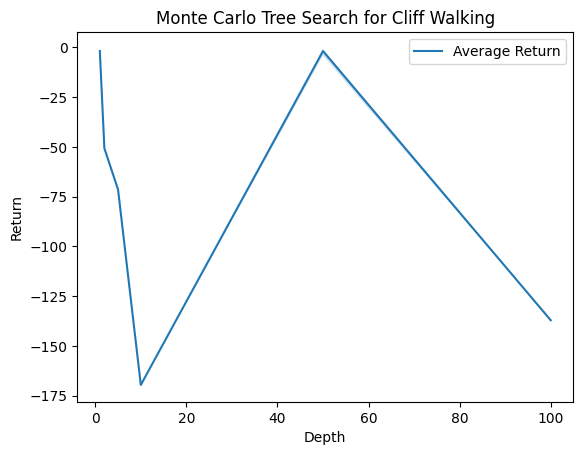

In [76]:
def test_cliff_walking_depth(mcts,iterations=1000,depth=10):
    
    mcts = MonteCarloSearchTree(env)
    # Convert initial state (0,0) to integer representation
    mcts.root.state = 0  # (0 * 12 + 0)
    values = []
    mcts.depth_limit = depth
    for _ in tqdm(range(5)):
        p,value = mcts.get_best_action(iterations)
        values.append(value)
    return min(values), max(values), sum(values)/len(values)

depths=[1,2,5,10,50,100]
avg_returns_depth = []
min_returns_depth = [float('inf')] * len(depths) 
max_returns_depth = [float('-inf')] * len(depths)

for depth in tqdm(depths,desc=f'Depth'):
    min_return, max_return, avg_return = test_cliff_walking_depth(depth)
    min_returns_depth[depths.index(depth)] = min_return
    max_returns_depth[depths.index(depth)] = max_return
    avg_returns_depth.append(avg_return)
    

plt.plot(depths, avg_returns_depth, label='Average Return')
plt.plot(depths, min_returns_depth, label='Min Return')
plt.plot(depths, max_returns_depth, label='Max Return')
plt.fill_between(depths, min_returns_depth, max_returns_depth, alpha=0.2)
# plt.xscale('log')
plt.xlabel('Depth')
plt.ylabel('Return')
plt.title('Monte Carlo Tree Search for Cliff Walking')
plt.legend()
plt.show()


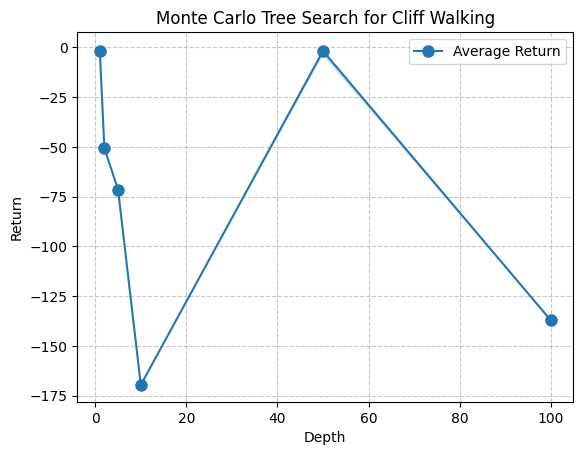

In [86]:
plt.plot(depths, avg_returns_depth, 'o-', label='Average Return', markersize=8)
plt.fill_between(depths, min_returns_depth, max_returns_depth, alpha=0.2)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlabel('Depth')
plt.ylabel('Return')
plt.title('Monte Carlo Tree Search for Cliff Walking')
plt.legend()
plt.show()